In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys

import csv
import datetime
import itertools
import numpy as np
import pandas as pd
import random
import re
import sklearn
import time
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(rc={
       "figure.figsize": (16, 10),
       "axes.titlesize": 14})

from IPython.display import Image, display
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

from os.path import expanduser
sys.path.insert(1, '{}/datsci'.format(expanduser('~')))
from datsci import eda, munge
from datsci import kaggle as kg

In [42]:
ll -h data

total 406904
-rw-r--r--@ 1 hqmac028  staff   612K Feb 24 23:09 sample_submission.csv
-rw-r--r--@ 1 hqmac028  staff    56M Feb 24 23:08 test.csv
-rw-r--r--@ 1 hqmac028  staff    57M Feb 24 23:08 train.csv
-rw-r--r--  1 hqmac028  staff    85M Mar 15 00:53 train.dedup.csv


In [43]:
FILE_TEST = 'data/test.csv'
FILE_TRAIN = 'data/train.csv'
FILE_TRAIN_DEDUP = 'data/train.dedup.csv'
FILE_SAMPLE_SUBMIT = 'data/sample_submission.csv'

## Remove duplicates

In [3]:
def dedup():
    # Read data from file
    df = pd.read_csv(FILE_TRAIN, index_col='ID')

    # Remove duplicate rows
    df.drop_duplicates(inplace=True)

    # Remove constant columns
    df.drop(eda.find_const_cols(df), axis=1, inplace=True)
    
    # Remove duplicate columns and then rows again
    df = munge.remove_duplicates(df.T).T.drop_duplicates()
    
    # Write to file
    df.to_csv(FILE_TRAIN_DEDUP, index=False)

if not os.path.exists(FILE_TRAIN_DEDUP):
    dedup()

## Find NaNs

### Data processing thread
https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19291/data-dictionary/111360

In [67]:
df_test = pd.read_csv(FILE_TEST, index_col='ID')

In [34]:
df = pd.read_csv(FILE_TRAIN_DEDUP)

In [41]:
df.TARGET.value_counts()

0.0    68398
1.0     2815
Name: TARGET, dtype: int64

In [35]:
# Find columns with extreme values
extreme_cols = eda.find_extreme_cols(df, T=1000)

In [44]:
# Find binary columns
binary_cols = eda.find_binary_cols(df)

In [61]:
binary_cols2 = eda.find_n_nary_cols(df, n=2)

In [72]:
trinary_cols = eda.find_n_nary_cols(df, n=3)

In [74]:
quaternary_cols = eda.find_n_nary_cols(df, n=4)

In [73]:
len(trinary_cols)

26

In [75]:
len(quaternary_cols)

20

In [63]:
len(binary_cols), len(binary_cols2)

(57, 86)

In [76]:
df[quaternary_cols[0]].value_counts()

0.0     67760
3.0      3415
6.0        37
15.0        1
Name: num_var12, dtype: int64

In [65]:
df.delta_imp_amort_var18_1y3.value_counts()

0.000000e+00    71211
1.000000e+10        2
Name: delta_imp_amort_var18_1y3, dtype: int64

In [66]:
df.delta_imp_amort_var34_1y3.value_counts()

0.000000e+00    71211
1.000000e+10        2
Name: delta_imp_amort_var34_1y3, dtype: int64

In [69]:
df_test.delta_imp_amort_var18_1y3.value_counts()

0             75817
9999999999        1
Name: delta_imp_amort_var18_1y3, dtype: int64

In [64]:
set(binary_cols2) - set(binary_cols)

{'delta_imp_amort_var18_1y3',
 'delta_imp_amort_var34_1y3',
 'delta_imp_reemb_var13_1y3',
 'delta_imp_reemb_var33_1y3',
 'delta_imp_trasp_var17_out_1y3',
 'delta_imp_trasp_var33_out_1y3',
 'imp_reemb_var17_hace3',
 'imp_reemb_var33_ult1',
 'imp_trasp_var33_out_ult1',
 'num_meses_var13_medio_ult3',
 'num_reemb_var13_ult1',
 'num_reemb_var17_hace3',
 'num_reemb_var33_ult1',
 'num_trasp_var17_in_ult1',
 'num_trasp_var17_out_ult1',
 'num_trasp_var33_in_hace3',
 'num_trasp_var33_out_ult1',
 'num_var13_medio_0',
 'num_var18_0',
 'num_var20',
 'num_var20_0',
 'num_var34_0',
 'num_var40',
 'num_var44',
 'num_var6',
 'num_var6_0',
 'num_var7_emit_ult1',
 'num_var8',
 'saldo_medio_var29_hace3'}

In [45]:
len(binary_cols)

57

In [36]:
len(extreme_cols)

127

In [71]:
len(set(binary_cols2) & set(extreme_cols))

9

In [51]:
ind_cols = list(c for c in list(df.columns) if c[:4] == 'ind_')

In [52]:
set(binary_cols) - set(ind_cols)

{'TARGET'}

In [57]:
foo = df[binary_cols[0]].value_counts()

In [58]:
type(foo)

pandas.core.series.Series

### var3

In [16]:
df[df.var3 == -999999].shape

(107, 307)

In [39]:
df['var3'] = df.var3.replace(-999999, np.nan)

In [27]:
df.var3.describe()

count    71106.000000
mean         2.766053
std          9.767036
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        238.000000
Name: var3, dtype: float64

In [28]:
df[df.var3 == 238].shape

(1, 307)

In [30]:
df.var3.dropna().sort_values()[-3:]

24978    231.0
6791     235.0
66940    238.0
Name: var3, dtype: float64

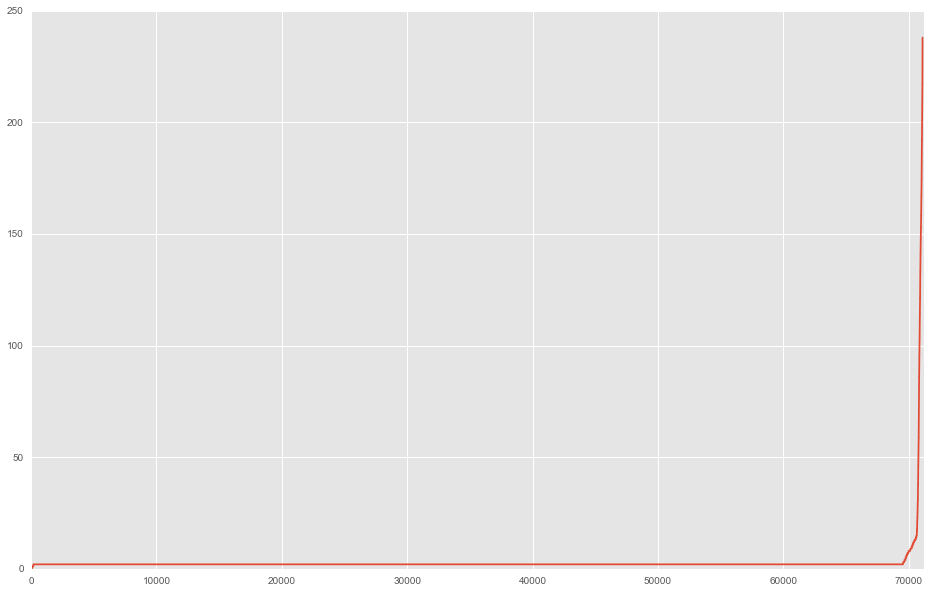

In [33]:
pd.Series(df.var3.sort_values().values).plot()

In [40]:
df[extreme_cols[1]].describe()

count     71213.000000
mean         92.027471
std        1668.207086
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      210000.000000
Name: imp_ent_var16_ult1, dtype: float64

In [ ]:
df.imp_ent_var16_ult1.